In [1]:
import random
import os
import numpy as np
import torch

def seed_everything(seed):
    """
    """
    # 1. Python & Numpy
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    # 2. PyTorch (CPU & GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"🔒 Locked Random Seed: {seed}")

# --- GỌI HÀM ---
seed_everything(10)

🔒 Locked Random Seed: 10


In [2]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
from scipy.stats import kendalltau

In [3]:
#load data
df_men = pd.read_csv(r"C:\Users\Lenovo\Documents\Neu 2025-2026\Lab\Hillstrom-Men.csv")
df_men = df_men.drop(columns="Unnamed: 0")
print ("---------------------------")
print ("null count:")
print (df_men.isnull().sum())
print ("---------------------------")
print(df_men.dtypes)
print ("---------------------------")
print ("labels:")
print(df_men.columns.tolist())
print ("---------------------------")
print("data shape:")
print(df_men.shape)


---------------------------
null count:
recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
visit              0
conversion         0
spend              0
treatment          0
dtype: int64
---------------------------
recency              int64
history_segment     object
history            float64
mens                 int64
womens               int64
zip_code            object
newbie               int64
channel             object
visit                int64
conversion           int64
spend              float64
treatment            int64
dtype: object
---------------------------
labels:
['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel', 'visit', 'conversion', 'spend', 'treatment']
---------------------------
data shape:
(42613, 12)


In [4]:
#Hillstrom-men
#split num and cate
num_cols = df_men.select_dtypes(include=["float64", "int64"]).columns
cate_cols = ['zip_code', 'channel']
df_men["history_segment"] =df_men["history_segment"].map({
    "1) $0 - $100": '1', 
    "2) $100 - $200": 2, 
    "3) $200 - $350": "3",
    "4) $350 - $500": "4",
    "5) $500 - $750": "5",
    "6) $750 - $1,000": "6",
    "7) $1,000 +": "7"                         
})
#split x y t
y_men = df_men["spend"]
t_men = df_men["treatment"]
x_men = df_men.drop(columns=["spend", "treatment", "visit", "conversion"])

x_men_encode = pd.get_dummies(x_men, columns=cate_cols, drop_first=True)
#train test split
x_men_train, x_men_test_val,t_men_train, t_men_test_val, y_men_train, y_men_test_val = train_test_split(x_men_encode,t_men.values, y_men.values, test_size=0.4, random_state=42, stratify=t_men)
x_men_val, x_men_test, t_men_val, t_men_test, y_men_val, y_men_test = train_test_split(x_men_test_val, t_men_test_val, y_men_test_val, test_size= 0.75, random_state=42, stratify=t_men_test_val)

#scale
scaler = StandardScaler()
x_men_train = scaler.fit_transform(x_men_train)
x_men_val = scaler.transform(x_men_val)
x_men_test = scaler.transform(x_men_test)

In [5]:
#Transform to tensor
def to_tensor(df):
    return torch.tensor(df, dtype=torch.float32)

x_men_train_t = to_tensor(x_men_train)
x_men_val_t = to_tensor(x_men_val)
x_men_test_t = to_tensor(x_men_test)

y_men_train_t = to_tensor(y_men_train).unsqueeze(1)
y_men_val_t = to_tensor(y_men_val).unsqueeze(1)
y_men_test_t = to_tensor(y_men_test).unsqueeze(1)

t_men_train_t = to_tensor(t_men_train.astype(float)).unsqueeze(1)
t_men_val_t = to_tensor(t_men_val.astype(float)).unsqueeze(1)
t_men_test_t = to_tensor(t_men_test.astype(float)).unsqueeze(1)

#Data loader
train_dataset = TensorDataset(x_men_train_t, t_men_train_t, y_men_train_t)
val_dataset = TensorDataset(x_men_val_t, t_men_val_t, y_men_val_t)
test_dataset = TensorDataset(x_men_test_t, t_men_test_t, y_men_test_t)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print ("-------------------------------------------------------------")
print ("✅Completed tranform to tensor✅")
print (f"Shape of train: x={x_men_train_t.shape}; y ={y_men_train_t.shape}; t={t_men_train_t.shape}")
print (f"Shape of val: x={x_men_val_t.shape}; y={y_men_val_t.shape}; t={t_men_val_t.shape}")
print (f"Shape of test: x={x_men_test_t.shape}; y={y_men_test_t.shape}; t={t_men_test_t.shape}")



-------------------------------------------------------------
✅Completed tranform to tensor✅
Shape of train: x=torch.Size([25567, 10]); y =torch.Size([25567, 1]); t=torch.Size([25567, 1])
Shape of val: x=torch.Size([4261, 10]); y=torch.Size([4261, 1]); t=torch.Size([4261, 1])
Shape of test: x=torch.Size([12785, 10]); y=torch.Size([12785, 1]); t=torch.Size([12785, 1])


Evaluation metrics

In [6]:
from metrics import auuc, auqc, lift, krcc

Build Model

In [7]:
from dragonnet import Dragonnet

In [8]:
dragonnet = Dragonnet(input_dim=x_men_train_t.shape[1], epochs=50,ranking_lambda=1.0, alpha = 1.0, beta =1.0, learning_rate=0.001)
dragonnet.fit(train_loader, val_loader)

print ("Complete training")

🔃🔃🔃Begin training Dragonnet🔃🔃🔃


IndexError: too many indices for tensor of dimension 1

Evaluating baseline🔃🔃🔃


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24584\1805000247.py:187: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bin_stats = data.groupby('bucket').apply(


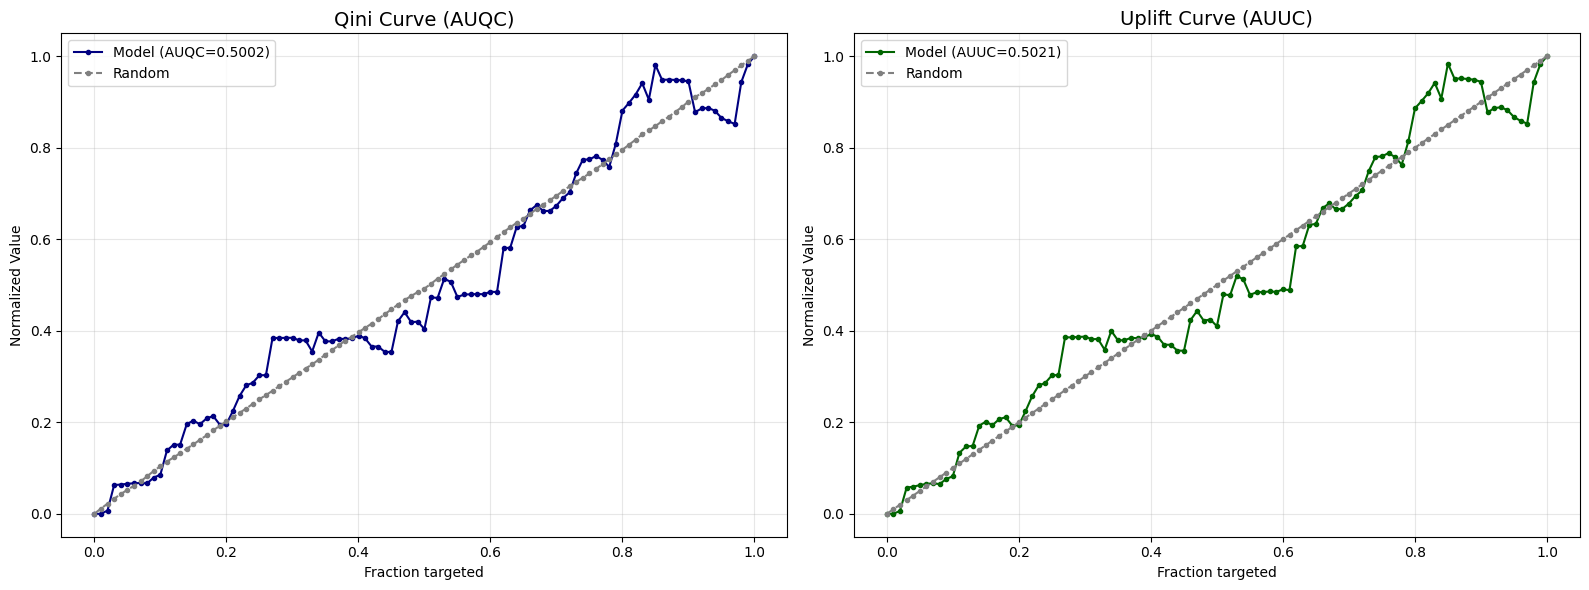

----------------------------------------
 Evaluation 
AUUC: 0.50210
Lift30: 0.9825
KRCC: 0.0129
AUQC: 0.50016
----------------------------------------


In [ ]:
print ("Evaluating baseline🔃🔃🔃")
y0_pred, y1_pred, _,_ = dragonnet.predict(x_men_test_t)

uplift_pred = (y1_pred - y0_pred).numpy().flatten()

y_true = y_men_test_t.numpy().flatten()
t_true = t_men_test_t.numpy().flatten()

auuc = auuc(y_true, t_true, uplift_pred, bins=100, plot=True)
auqc = auqc(y_true, t_true, uplift_pred, bins=100, plot=True)
lift = lift(y_true, t_true, uplift_pred, h=0.3, bins=100)
krcc = krcc(y_true, t_true, uplift_pred, bins= 100)

print ("-"*40)
print ("AUUC: ", auuc)
print ("AUQC: ", auqc)
print ("Lift: ", lift)
print ("KRCC: ", krcc)